*J. Michelle Hu  
University of Washington  
Winter 2022*

# TODO
## Ok now loop it all and put it into the csv by area of interest (input grid cell)

Need to calculate on the fly and add these to df
- L8_meanNDVI  
- L8_meanNDSI  

others...
- L8_meanThermal  
- L8_meanBands??  
- L8_minNDVI
- L8_maxNDVI
- L8_minNDSI  
- L8_maxNDSI  
  
Likely want to compute an fSCA and a fractional vegetation cover (FVC)
binary snow with thresh NDSI > 0.4, then compute mean
binary tree (based on date) with thresh

Probably also want to flag and handle cloudy pixels

In [1]:
# Load dependencies
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
import geojson

from datetime import date
from datetime import timedelta

In [2]:
def search_catalog(client, time_of_interest, cell, cloud_cover_thresh, collections=["landsat-8-c2-l2"]):
    search = client.search(
        collections=collections,
        intersects={"type":"Polygon", "coordinates":cell['geometry']['coordinates']},
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": cloud_cover_thresh}},
    )
    return search

In [3]:
# user-defined paths for data-access
data_dir = "SnowCast_data/"
gridcells_file = f"{data_dir}grid_cells.geojson"
stations_file = f"{data_dir}ground_measures_metadata.csv"

# Load metadata
gridcells = geojson.load(open(gridcells_file))
stations = pd.read_csv(stations_file)

## Testing

In [4]:
# Pull Landsat imagery for each grid cell , limiting by time_of_interest and cloud cover threshold
# Format "2020-01-01/2020-12-31"

# input day
datestamp="2017-02-01"
time_delta = 7 #days
time_of_interest = f"{date.fromisoformat(datestamp)-timedelta(days=time_delta)}/{date.fromisoformat(datestamp) + timedelta(days=time_delta)}"
cloud_cover_thresh = 100
print(time_of_interest)

client = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

for idx, area_of_interest in enumerate(gridcells['features']):
    print(idx)    
    search=search_catalog(client=client, time_of_interest=time_of_interest, cell=area_of_interest, collections=["landsat-8-c2-l2"], cloud_cover_thresh=cloud_cover_thresh)
    
    # Check how many items were returned
    items = list(search.get_items())   
    print(f"Returned {len(items)} Items")
#    td=time_delta
#    # Adjust time delta bounds if no images for site within time period
#     if len(items)==0:
#         for day in range(7):
#             print(day)
#             time_of_interest=f"{date.fromisoformat(datestamp)-timedelta(days=td+day)}/{date.fromisoformat(datestamp) + timedelta(days=td+day)}"
#             search_catalog(time_of_interest, cell, collections=["landsat-8-c2-l2"], query={"eo:cloud_cover": {"lt": cloud_cover_thresh}})

#             # Check how many items were returned
#             items = list(search.get_items())   
#             print(f"Returned {len(items)} Items")

    if idx==3:
        break


2017-01-25/2017-02-08
0
Returned 2 Items
1
Returned 2 Items
2
Returned 1 Items
3
Returned 1 Items


In [5]:
if len(items)>0:
    selected_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]
else:
    selected_item = items[0]

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_042034_20170208_02_T1 from 2017-02-08 with 64.69% cloud cover


#### Band designations https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites
For NDVI, we need red (b4) and nir (b5)  
For NDSI, we need green (b3) and swir (b6)
For LST, we need thermal (b10)

In [6]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [7]:
# Check out the common names
for asset in selected_item.assets.values():
    asset_bands = eo.ext(asset).bands
    # print("\n")
    print(asset_bands)
    if asset_bands is not None:
        print(asset_bands[0].common_name)

None
[<Band name=SR_B1>]
coastal
[<Band name=SR_B2>]
blue
[<Band name=SR_B3>]
green
[<Band name=SR_B4>]
red
[<Band name=SR_B5>]
nir08
[<Band name=SR_B6>]
swir16
[<Band name=SR_B7>]
swir22
None
[<Band name=ST_B10>]
lwir11
None
None
[<Band name=ST_DRAD>]
None
[<Band name=ST_EMIS>]
None
[<Band name=ST_EMSD>]
None
[<Band name=ST_TRAD>]
None
[<Band name=ST_URAD>]
None
None
None
[<Band name=ST_ATRAN>]
None
[<Band name=ST_CDIST>]
None
None
None
None
None
None
None


In [8]:
asset_hrefs = [
    find_asset_by_band_common_name(selected_item, "green").href,
    find_asset_by_band_common_name(selected_item, "red").href,
    find_asset_by_band_common_name(selected_item, "nir08").href,
    find_asset_by_band_common_name(selected_item, "swir16").href,
    find_asset_by_band_common_name(selected_item, "lwir11").href,
]
asset_hrefs

['https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2017/042/034/LC08_L2SP_042034_20170208_20200905_02_T1/LC08_L2SP_042034_20170208_20200905_02_T1_SR_B3.TIF',
 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2017/042/034/LC08_L2SP_042034_20170208_20200905_02_T1/LC08_L2SP_042034_20170208_20200905_02_T1_SR_B4.TIF',
 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2017/042/034/LC08_L2SP_042034_20170208_20200905_02_T1/LC08_L2SP_042034_20170208_20200905_02_T1_SR_B5.TIF',
 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2017/042/034/LC08_L2SP_042034_20170208_20200905_02_T1/LC08_L2SP_042034_20170208_20200905_02_T1_SR_B6.TIF',
 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2017/042/034/LC08_L2SP_042034_20170208_20200905_02_T1/LC08_L2SP_042034_20170208_20200905_02_T1_ST_B10.TIF']

In [9]:
def read_band(href, area_of_interest):
    
    from rasterio import windows
    from rasterio import features
    from rasterio import warp
    
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)

#### Consider adding more indices

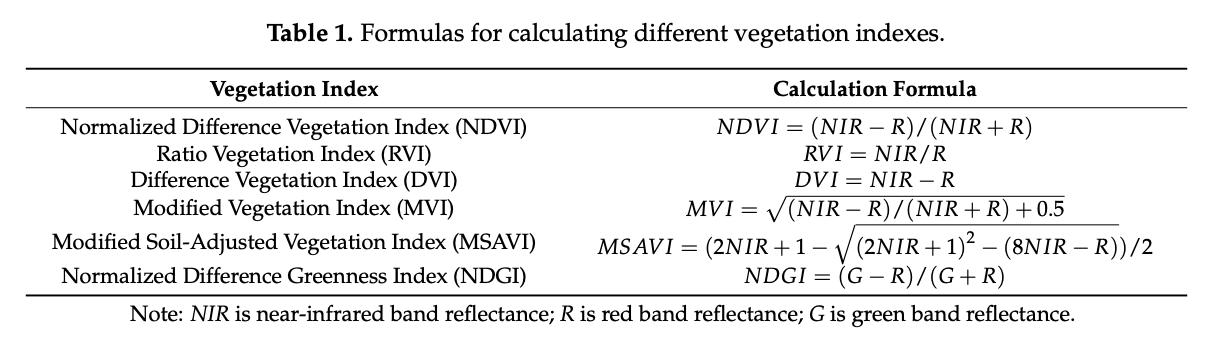

In [10]:
from IPython.display import Image
Image(filename='VegIndices_Table.png') 

In [11]:
# Calculate Indices
def calc_indices(area_of_interest, asset_hrefs=None):
    '''input either asset_hrefs = [green, red, nir, swir, lwir] or individual band assets'''
    
    signed_hrefs = [pc.sign(asset_href) for asset_href in asset_hrefs]
    asset_floats = [read_band(f, area_of_interest).astype(float) for f in signed_hrefs]
    g, r, nir, swir, _ = asset_floats

    ndvi = (nir - r) / (nir + r)
    ndsi = (g - swir) / (g + swir)
    
    #other indices to consider (see png)
    #rvi = nir/r
    #dvi = nir-r
    #mvi = np.sqrt((nir-r)/(nir+r)+0.5)
    #msavi = ( (2*nir+1) - np.sqrt( (2*nir+r)**2 - (8*nir-r) ) ) * 0.5
    #ndgi = (g - r) / (g + r)
    
    return ndvi, ndsi

In [12]:
%%time
ndvi, ndsi = calc_indices(area_of_interest=area_of_interest, asset_hrefs=asset_hrefs)

CPU times: user 73.7 ms, sys: 18.6 ms, total: 92.3 ms
Wall time: 1.25 s


#### Quick look

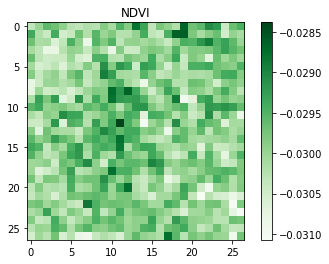

In [13]:
# dpi = 50
# w = ndvi.shape[0]
# h = ndvi.shape[1]
# fig = figure(figsize=(w / dpi, h / dpi), dpi=dpi, frameon=False)
# ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
# ax.set_axis_off()
# fig.add_axes(ax)
   
plt.imshow(ndvi, cmap="Greens", 
           # vmin=np.percentile(ndvi, 2), vmax=np.percentile(ndvi, 98)
          );
plt.title("NDVI")
plt.colorbar()

Text(0.5, 1.0, 'NDSI')

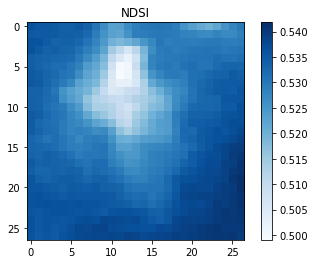

In [14]:
plt.imshow(ndsi, cmap="Blues", 
           # vmin=np.percentile(ndsi, 2), vmax=np.percentile(ndsi, 98)
          );
plt.colorbar()
plt.title("NDSI")

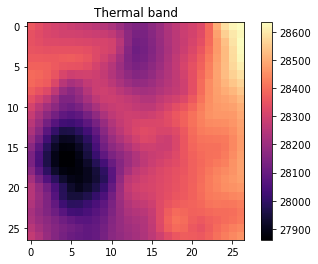

In [15]:
# Display thermal image
signed_hrefs = [pc.sign(asset_href) for asset_href in asset_hrefs]
thermal=read_band(signed_hrefs[-1], area_of_interest).astype(float)

plt.imshow(thermal, cmap="magma");
plt.title("Thermal band")
plt.colorbar()